In [1]:
import os,cv2,glob,tqdm,numpy as np, torch
from torch import nn,optim,utils
from torchsummary import summary
from torchvision import datasets,transforms,models,utils as tvu
from sklearn import metrics,model_selection as sms
from matplotlib import pyplot as plt

device  = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

## Dataset

## Model's arch

In [2]:
class AgaBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(AgaBlock,self).__init__()
        self.Wg = nn.Sequential(nn.Conv2d(in_c, out_c, 1), nn.BatchNorm2d(out_c))
        self.Ws = nn.Sequential(nn.Conv2d(out_c, out_c, 1), nn.BatchNorm2d(out_c))
        self.outp = nn.Sequential(nn.Conv2d(out_c, out_c, 1), nn.Sigmoid())
        self.relu = nn.ReLU(True)
 
    def forward(self, g, s):
        return self.outp(self.relu(self.Wg(g) + self.Ws(s)))
    
class EncBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = ConvNet(in_c, out_c)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv(x)
        return x, self.pool(x)
    
class DecBlock(nn.Module):
    def __init__(self, in_c, out_c, skip=0, up_sample_mode=False):
        super().__init__()
        self.skip = skip
        self.uper = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) if up_sample_mode else nn.ConvTranspose2d(in_c, in_c,2,2)
        self.conv = ConvNet(in_c+out_c if self.skip else in_c, out_c)
        self.gate = AgaBlock(in_c,out_c)

    def forward(self, inputs, skip=None):
        x = self.uper(inputs)
        if self.skip: 
            x = torch.cat([x, self.gate(x,skip) if self.skip==1 else skip], axis=1)
        return self.conv(x)

ConvNet = lambda inC, outC: nn.Sequential(
    nn.Conv2d(inC, outC, 3, padding=1), nn.BatchNorm2d(outC),nn.ReLU(True),
    nn.Conv2d(outC,outC, 3, padding=1), nn.BatchNorm2d(outC),nn.ReLU(True)
)
    
class UNet(nn.Module):
    '''
    skip: 0=NoSkip-UNet, 1=AG-UNet, 2=UNet std
    '''
    def __init__(self,skip,ok=64,depth=4,classes=3):
        super().__init__()
        self.skip = skip
        self.depth = depth

        #Downsampling 
        convs = [EncBlock(3,ok)]
        for _ in range(1,self.depth):
            convs.append(EncBlock(ok,ok*2))
            ok *=2
        self.enc = nn.Sequential(*convs)

        #Bottlene
        self.tra = ConvNet(ok,ok*2)

        #Upsampling
        convs = [DecBlock(ok*2,ok,self.skip)]
        for _ in range(1,self.depth):
            convs.append(DecBlock(ok,ok//2,self.skip))
            ok //=2
        self.dec = nn.Sequential(*convs)

        # Classifier
        self.out = nn.Conv2d(ok, classes, 1)

    def forward(self, x):
        """ Encoder """
        encs = []
        for block in self.enc:
            s,x = block(x)
            encs.append(s)

        """ Bottleneck """
        x = self.tra(x)

        """ Decoder """
        for i,block in enumerate(self.dec):
            x = block(x, encs[self.depth-i-1]) if self.skip else block(x)

        """ Classifier """
        return self.out(x)

unet = UNet(2,16,5) #.to(device)
summary(unet,(3,256,256),-1,'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           2,320
       BatchNorm2d-5         [-1, 16, 256, 256]              32
              ReLU-6         [-1, 16, 256, 256]               0
         MaxPool2d-7         [-1, 16, 128, 128]               0
          EncBlock-8  [[-1, 16, 256, 256], [-1, 16, 128, 128]]               0
            Conv2d-9         [-1, 32, 128, 128]           4,640
      BatchNorm2d-10         [-1, 32, 128, 128]              64
             ReLU-11         [-1, 32, 128, 128]               0
           Conv2d-12         [-1, 32, 128, 128]           9,248
      BatchNorm2d-13         [-1, 32, 128, 128]              64
             ReLU-14    

In [3]:
onet = UNet(0,16,5) #.to(device)
summary(onet,(3,256,256),-1,'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           2,320
       BatchNorm2d-5         [-1, 16, 256, 256]              32
              ReLU-6         [-1, 16, 256, 256]               0
         MaxPool2d-7         [-1, 16, 128, 128]               0
          EncBlock-8  [[-1, 16, 256, 256], [-1, 16, 128, 128]]               0
            Conv2d-9         [-1, 32, 128, 128]           4,640
      BatchNorm2d-10         [-1, 32, 128, 128]              64
             ReLU-11         [-1, 32, 128, 128]               0
           Conv2d-12         [-1, 32, 128, 128]           9,248
      BatchNorm2d-13         [-1, 32, 128, 128]              64
             ReLU-14    

In [4]:
anet = UNet(1,16,5) #.to(device)
summary(anet,(3,256,256),-1,'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           2,320
       BatchNorm2d-5         [-1, 16, 256, 256]              32
              ReLU-6         [-1, 16, 256, 256]               0
         MaxPool2d-7         [-1, 16, 128, 128]               0
          EncBlock-8  [[-1, 16, 256, 256], [-1, 16, 128, 128]]               0
            Conv2d-9         [-1, 32, 128, 128]           4,640
      BatchNorm2d-10         [-1, 32, 128, 128]              64
             ReLU-11         [-1, 32, 128, 128]               0
           Conv2d-12         [-1, 32, 128, 128]           9,248
      BatchNorm2d-13         [-1, 32, 128, 128]              64
             ReLU-14    

## Model's training

## Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


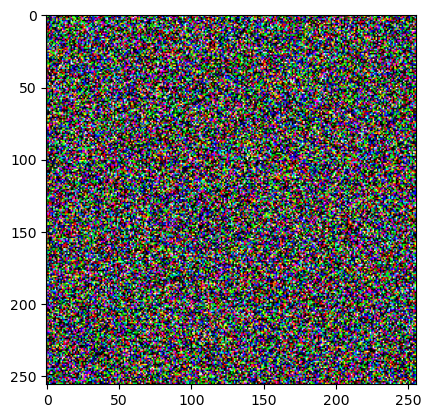

In [14]:
x = torch.randn((2,3,256,256))
plt.imshow(np.transpose(x[0],(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


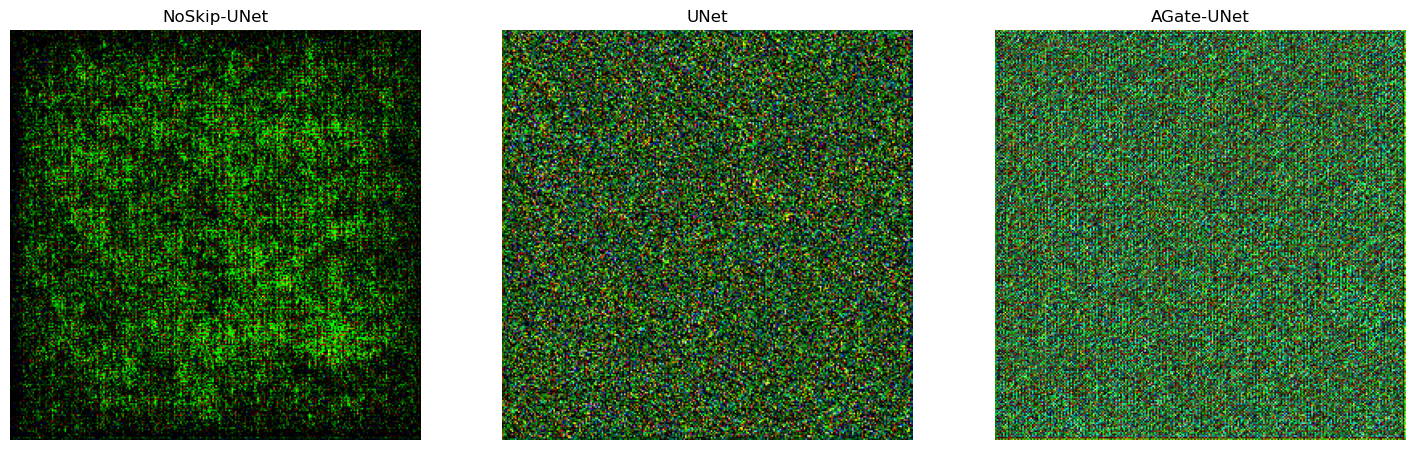

In [15]:
fg,ax = plt.subplots(1,3,figsize=(18,9)); ok=[]
with torch.no_grad(): 
    ok.append((onet(x).cpu().numpy(),'NoSkip-UNet'))
    ok.append((unet(x).cpu().numpy(),'UNet'))
    ok.append((anet(x).cpu().numpy(),'AGate-UNet'))
for i,(v,k) in enumerate(ok): 
    ax[i].imshow(np.transpose(v[0],(1,2,0)))
    ax[i].set_title(k); ax[i].axis('off')